In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import re
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

In [5]:
test_data = pd.read_parquet("../data/second_departure_parquet_feats/sample_06.09.2022_all_features.parquet")

In [6]:
test_data.head()

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,bearing_corr,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.205053,0.082422,0.014212,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882
1,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.144063,0.052211,0.011149,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306
2,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.306874,0.012220,0.001329,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.046329,0.009875,0.011567,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,8A8813E7-6012-4600-835D-1C286EADE837,37.602763,55.892618,0.203208,0.009416,...,0.204592,0.112317,0.010256,0.058706,0.119389,3.765288,0.098938,10.963710,38.229802,39.078068


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1679 non-null   datetime64[ns]
 1   datetime                   1679 non-null   datetime64[ns]
 2   dev_id_1                   1679 non-null   object        
 3   id_1_last_lon              1679 non-null   float64       
 4   id_1_last_lat              1679 non-null   float64       
 5   dev_id_2                   1679 non-null   object        
 6   id_2_last_lon              1679 non-null   float64       
 7   id_2_last_lat              1679 non-null   float64       
 8   accelerometer_x_corr       1411 non-null   float64       
 9   accelerometer_x_diff_corr  1411 non-null   float64       
 10  accelerometer_y_corr       1492 non-null   float64       
 11  accelerometer_y_diff_corr  1492 non-null   float64       
 12  accele

In [2]:
data = pd.read_parquet("../../data/02_interim/sample_06_12_all_features.parquet")

In [3]:
list_of_files = list()
for (dirpath, dirnames, filenames) in os.walk("../../data/01_raw/second_departure_parquet_preprocessed/"):
    list_of_files += [os.path.join(dirpath, file) for file in filenames if ".parquet" in file]

In [12]:
list_of_files = [each for each in list_of_files if "Данные" in each]

In [13]:
second_device = [each for each in list_of_files if "устройство" in each]

In [16]:
def get_date_from_filename(filename):
    filename_list = filename.replace('.parquet', '').split("_")
    for each in filename_list:
        found_date = re.search("[0-9][0-9](.)[0-9][0-9](.)20[0-9][0-9]$", each)
        if found_date is not None:
            return found_date.group()

In [17]:
def find_original_file(path, date):
    all_files = os.listdir(path)
    all_files = [each for each in all_files if date in each]
    all_files = [each for each in all_files if "устройство" not in each]
    return all_files

In [21]:
import os


files = []
for path in second_device:
    folder = path.rsplit("/", 1)[0]  # тут мб поменяете на обратный слеш \ для винды
    date = get_date_from_filename(path)
    original_filepath = find_original_file(folder, date)
    if len(original_filepath) < 1:
        original_filepath = np.nan
    else:
        original_filepath = os.path.join(folder, original_filepath[0])
    files.append((path, original_filepath))

In [22]:
targets_df = []
for second_filepath, initial_filepath in files:
    if len(initial_filepath) != 0:
        second_df = pd.read_parquet(second_filepath)
        initial_df = pd.read_parquet(initial_filepath)
        date = initial_df["Время отправки гео"].dt.to_period("D").dt.to_timestamp()[0]
        second_name = second_df["Наименование (device ID)"][0]
        initial_name = initial_df["Наименование (device ID)"][0]
        tmp_df = pd.DataFrame([[date, second_name, initial_name]], columns=["date", "sec_name", "init_name"])
        targets_df.append(tmp_df)

In [23]:
targets_df = pd.concat(targets_df, ignore_index=True)

In [24]:
data_final = data.copy(deep=True)
for _, row in targets_df.iterrows():
    date_condition = data["date"] == row["date"]
    comparison_condition_1 = (data["dev_id_1"] == row["sec_name"]) & (data["dev_id_2"] == row["init_name"])
    comparison_condition_2 = (data["dev_id_2"] == row["sec_name"]) & (data["dev_id_1"] == row["init_name"])
    comparison_condition = comparison_condition_1 | comparison_condition_2
    condition = date_condition & comparison_condition
    data_final.loc[condition, "target"] = 1

In [25]:
data_final

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std,target
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.082422,1.421230e-02,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882,NaN
1,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.012220,1.329316e-03,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099,NaN
2,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.052211,1.114944e-02,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306,NaN
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.009875,1.156702e-02,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189,NaN
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,AE6C3F14-5263-4BF1-AD06-3A8CE0A27AAB,37.603368,55.892132,0.157693,0.012551,...,0.023942,5.139841e-03,0.754217,0.042451,4.843979,1.013350,12.424083,17.029361,15.709145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,2022-09-12,2022-09-12 17:21:39,2D7135B3-1208-45BA-9B5A-0FC27C13B9B0,37.611783,55.892302,329C29F6-A464-4174-867E-50D7D163206C,37.610464,55.891030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6548,2022-09-12,2022-09-12 17:21:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.610962,55.887849,0.793525,0.601976,...,0.665669,NaN,NaN,0.619808,3.918556,2.154666,7.304032,98.934811,30.686367,NaN
6549,2022-09-12,2022-09-12 17:26:39,329C29F6-A464-4174-867E-50D7D163206C,37.610725,55.890972,55464DF0-C385-4349-801B-C8E1CB861CB5,37.610891,55.890427,0.025361,0.161036,...,0.070157,1.767547e-18,0.000059,0.050241,3.430670,-1.592060,9.831637,65.952005,7.381049,NaN
6550,2022-09-12,2022-09-12 17:26:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.611027,55.887835,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [14]:
data_final.reset_index(drop=True, inplace=True)

In [15]:
data_final["target"] = data_final["target"].fillna(0)

In [16]:
data_final["target"].value_counts()

0.0    5372
1.0    1180
Name: target, dtype: int64

In [17]:
data_final.reset_index(drop=True, inplace=True)
X = data_final.iloc[:, 8:-1]
# X = X.dropna(how="any")
X = X.fillna(-999)
y = data_final.loc[X.index, "target"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [21]:
features = X_train.columns.to_list()

In [22]:
import yaml

In [26]:
with open("features.yaml", "w") as fin:
    yaml.safe_dump(features, fin)

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [28]:
from sklearn.metrics import roc_auc_score

In [54]:
y_test_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.9364356674576679

In [69]:
from sklearn.metrics import precision_recall_curve

In [78]:
precision, recall, threshes = precision_recall_curve(y_test, y_test_pred)

In [75]:
import matplotlib.pyplot as plt

In [90]:
threshes[165]

0.416

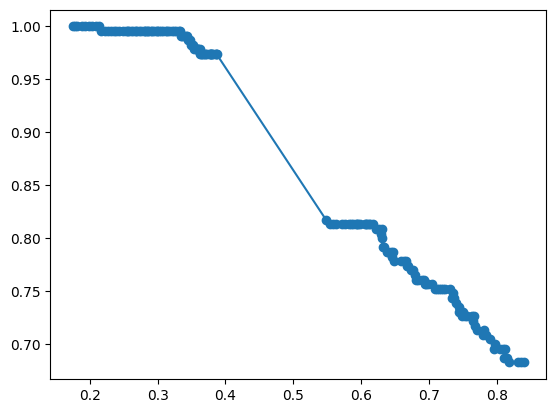

In [97]:
n = 165
plt.plot(precision[:n], recall[:n], marker='o')

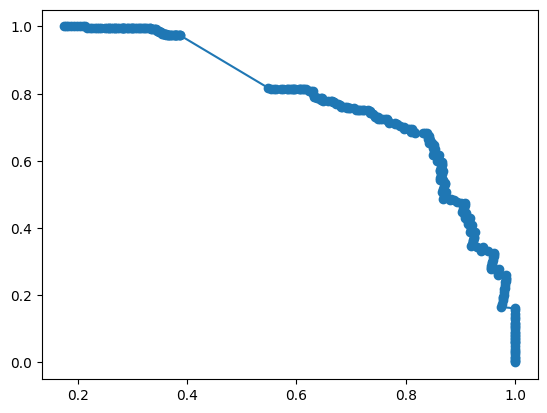

In [77]:
plt.plot(precision, recall, marker='o')

In [87]:
y_thresh = (y_test_pred > 0.5).astype(int)
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      1081
         1.0       0.86      0.57      0.69       230

    accuracy                           0.91      1311
   macro avg       0.89      0.78      0.82      1311
weighted avg       0.91      0.91      0.90      1311



In [109]:
y_thresh = (y_test_pred >= 0.416).astype(int)
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1081
         1.0       0.83      0.67      0.75       230

    accuracy                           0.92      1311
   macro avg       0.88      0.82      0.85      1311
weighted avg       0.92      0.92      0.92      1311



In [98]:
best_thresh = 0.416
sample_data = X_train.head(100) # fill na with "-999"
sample_data.to_csv("./random_forest_sample_data_thresh_0416.csv")

import pickle

with open("./random_forest_model.pkl", 'wb') as fin:
    pickle.dump(rf, fin)

In [100]:
X_train_columns = X_train.columns

In [103]:
rf.predict_proba(data_final[X_train_columns].fillna(-999))[:, 1]

array([0.01      , 0.034     , 0.        , ..., 0.012     , 0.15047577,
       0.004     ])

In [104]:
data_final["predicted_proba"] = rf.predict_proba(data_final[X_train_columns].fillna(-999))[:, 1]

In [105]:
data_final["thresh"] = 0.416

In [115]:
data_final["label"] = (data_final["predicted_proba"] > data_final["thresh"]).astype(int)

In [117]:
relevant_columns = ["datetime", "dev_id_1", "id_1_last_lon", "id_1_last_lat", 
                    "dev_id_2", "id_2_last_lon", "id_2_last_lat", 
                    "target", "predicted_proba", "thresh", "label"]

In [119]:
data_final[relevant_columns].to_csv("../../data/04_analytical_report/02_deviation_detection_report.csv", index=False)

In [30]:
y_test_pred = rf.predict(X_test)

In [31]:
from sklearn.metrics import classification_report

In [35]:
from sklearn.metrics import precision_recall_fscore_support

In [47]:
y_test_pred_thresh = (y_test_pred > 0.01).astype(int)
print(classification_report(y_test, y_test_pred_thresh))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      1081
         1.0       0.86      0.57      0.69       230

    accuracy                           0.91      1311
   macro avg       0.89      0.78      0.82      1311
weighted avg       0.91      0.91      0.90      1311



In [32]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      1081
         1.0       0.86      0.57      0.69       230

    accuracy                           0.91      1311
   macro avg       0.89      0.78      0.82      1311
weighted avg       0.91      0.91      0.90      1311



In [33]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4291
         1.0       1.00      0.84      0.91       950

    accuracy                           0.97      5241
   macro avg       0.98      0.92      0.95      5241
weighted avg       0.97      0.97      0.97      5241

